In [1]:
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [2]:
import lightning as L
import torch

In [3]:
from causalflows.scms import SCM, CausalEquations

In [4]:
class NapkinEquations(CausalEquations):
    def __init__(self):
        s = torch.nn.functional.softplus

        functions = [
            lambda u1: u1,  # U1
            lambda _1, u2: u2,  # U2
            lambda x1, x2, u3: 4*x1 - 2*x2 + u3,  # W
            lambda _1, _2, x3, u4: x3 + 0.5 * u4, # Z
            lambda _1, x2, _3, x4, u5: -x4 * 0.5 + x2 * 1.75 * u5, # X
            lambda x1, _2, _3, _4, x5, u6: x1 * 4 + x5**2 + u6, # Y
        ]
        inverses = [
            lambda x1: x1,
            lambda x1, x2: x2,
            lambda x1, x2, x3: x3 - (4*x1 - 2*x2),  # W
            lambda _1, _2, x3, x4: 2*(x4 - x3), # Z
            lambda _1, x2, _3, x4, x5: (x5 + x4 * 0.5) / (x2 * 1.75), # X
            lambda x1, _2, _3, _4, x5, x6: (x6 - (x1 * 4 + x5**2)), # Y
        ]

        super().__init__(functions, inverses)

    @property
    def adjacency(self):
        adj = torch.zeros((6, 6))
        adj[0, :] = torch.tensor([0, 0, 0, 0, 0, 0]) # z1
        adj[1, :] = torch.tensor([0, 0, 0, 0, 0, 0]) # z2
        adj[2, :] = torch.tensor([1, 1, 0, 0, 0, 0]) # w
        adj[3, :] = torch.tensor([0, 0, 1, 0, 0, 0]) # b
        adj[4, :] = torch.tensor([0, 1, 0, 1, 0, 0]) # t
        adj[5, :] = torch.tensor([1, 0, 0, 0, 1, 0]) # y
        adj += torch.eye(6)
        return adj.bool()


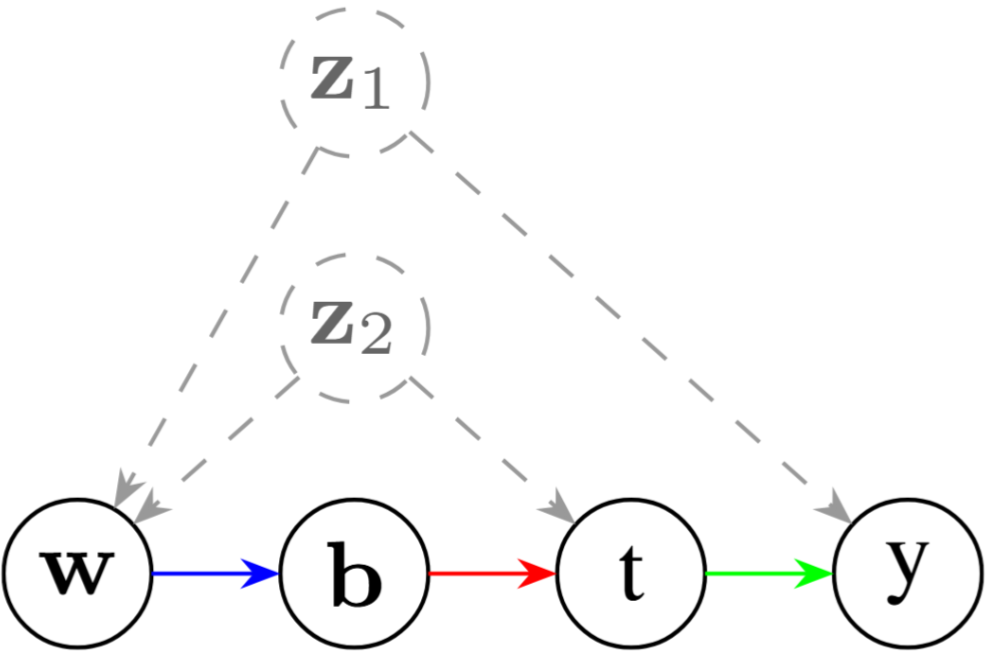

In [5]:
# insert ../assets/napkin_graph.png
from IPython.display import Image, display

display(Image(filename='../assets/napkin_graph.png'))

In [6]:
scm = SCM(equations=NapkinEquations(), base='std-gaussian')
def generate_data(size: int):
    return scm.sample((size,))
def generate_int_data(size: int, index, value):
    return scm.sample_interventional(index, value, (size,))
columns = ['Z1', 'Z2', 'W', 'B', 'T', 'Y']

In [7]:
x = scm.sample((1,))
x, scm.log_prob(x)

(tensor([[-1.0269, -0.6915, -3.2026, -3.3602, -0.6215, -3.0360]]),
 tensor([-7.9850]))

In [8]:
adjacency = scm.adjacency

In [9]:
from torch.utils.data import DataLoader, TensorDataset

In [10]:
num_hidden = 2
batch_size = 4096

train_size = 25000
train_data = generate_data(train_size)

test_size = int(train_size * 0.1)
test_data = generate_data(test_size)

# Standardize the data
mu, sigma = train_data.mean(dim=0), train_data.std(dim=0)
train_data = (train_data - mu) / sigma
test_data = (test_data - mu) / sigma

z_train, x_train = train_data[:, :num_hidden], train_data[:, num_hidden:]
z_test, x_test = test_data[:, :num_hidden], test_data[:, num_hidden:]

n_features = x_train.shape[1]

# Create the dataloaders
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True) #, num_workers=11)

test_dataset = TensorDataset(x_test)
test_loader = DataLoader(test_dataset, batch_size=test_size)

In [11]:
from decaflow.models import Encoder, Decoder, DeCaFlow
from decaflow.utils.logger import MyLogger
encoder = Encoder(flow_type='nsf', num_hidden=num_hidden, adjacency=adjacency,
                  features=num_hidden, context=n_features, hidden_features=[32, 32],
                  activation=torch.nn.ReLU)
decoder = Decoder(flow_type='nsf', num_hidden=num_hidden, adjacency=adjacency,
                  features=n_features, context=num_hidden, hidden_features=[32, 32, 32],
                  activation=torch.nn.ReLU)
unaware_decoder = Decoder(flow_type='nsf', num_hidden=0, adjacency=adjacency[num_hidden:, num_hidden:],
                    features=n_features, context=0, hidden_features=[32, 32, 32],
                    activation=torch.nn.ReLU)
scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_config = {'mode': 'min', 'factor': 0.95, 'patience': 50, 'verbose': True, 'cooldown':0}

decaflow = DeCaFlow(encoder=encoder, flow=decoder,
                    regularize=True, warmup=100,
                    lr=1e-3, optimizer_cls=torch.optim.Adam,
                    scheduler_cls=scheduler_cls,
                    scheduler_kwargs=scheduler_config,
                    scheduler_monitor='train_loss')
unaware_flow = DeCaFlow(encoder=None, flow=unaware_decoder, regularize=False,
                    lr=1e-3, optimizer_cls=torch.optim.Adam,
                    scheduler_cls=scheduler_cls,
                    scheduler_kwargs=scheduler_config,
                    scheduler_monitor='train_loss')

In [12]:
logger = MyLogger()
trainer = L.Trainer(max_epochs=500, logger=logger, enable_checkpointing=False, log_every_n_steps=len(train_loader)-1)
trainer.fit(decaflow, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Alex\anaconda3\envs\decaflow\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
C:\Users\Alex\anaconda3\envs\decaflow\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Alex\anaconda3\envs\decaflow\Lib\site-packages\lightning\pytorch\core\optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor', 'strict'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 2.8 K  | train
1 | flow    | Decoder | 5.4 K  | train
--------------------------------------------
8.2 K     Trai

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


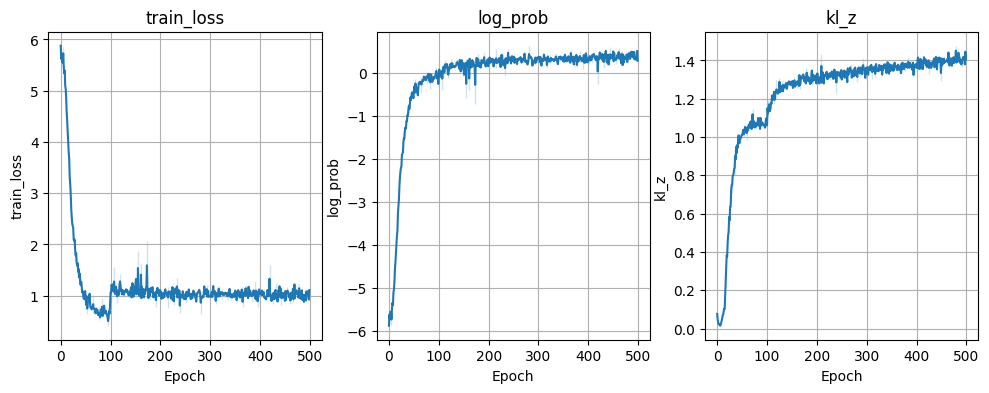

(1.110050082206726, 0.2936002314090729, 1.4036502838134766)

In [13]:
from decaflow.utils.plot import plot_logs
plot_logs(logger, columns=['train_loss', 'log_prob', 'kl_z'])
logger.values['train_loss'][-1], logger.values['log_prob'][-1], logger.values['kl_z'][-1]

In [14]:
logger_unaware = MyLogger()
trainer_unaware  = L.Trainer(max_epochs=500, logger=logger_unaware , enable_checkpointing=False, log_every_n_steps=len(train_loader)-1)
trainer_unaware.fit(unaware_flow, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Alex\anaconda3\envs\decaflow\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
C:\Users\Alex\anaconda3\envs\decaflow\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Alex\anaconda3\envs\decaflow\Lib\site-packages\lightning\pytorch\core\optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor', 'strict'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | flow | Decoder | 5.3 K  | train
-----------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K  

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


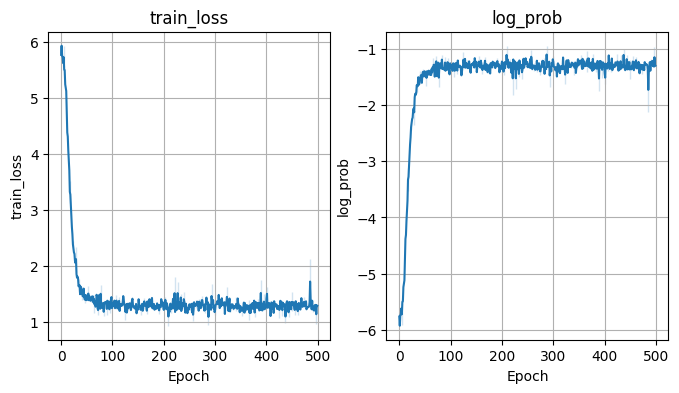

(1.294682264328003, -1.294682264328003)

In [15]:
plot_logs(logger_unaware, columns=['train_loss', 'log_prob'])
logger_unaware.values['train_loss'][-1], logger_unaware.values['log_prob'][-1]

In [16]:
x_gen, z_gen = decaflow.sample((test_size,))
gen_data = torch.cat((z_gen, x_gen), dim=1)
gen_data.shape

torch.Size([2500, 6])

In [17]:
x_gen_unaware, _ = unaware_flow.sample((test_size,))
gen_data_unaware = torch.cat((z_gen,x_gen_unaware), dim=1)

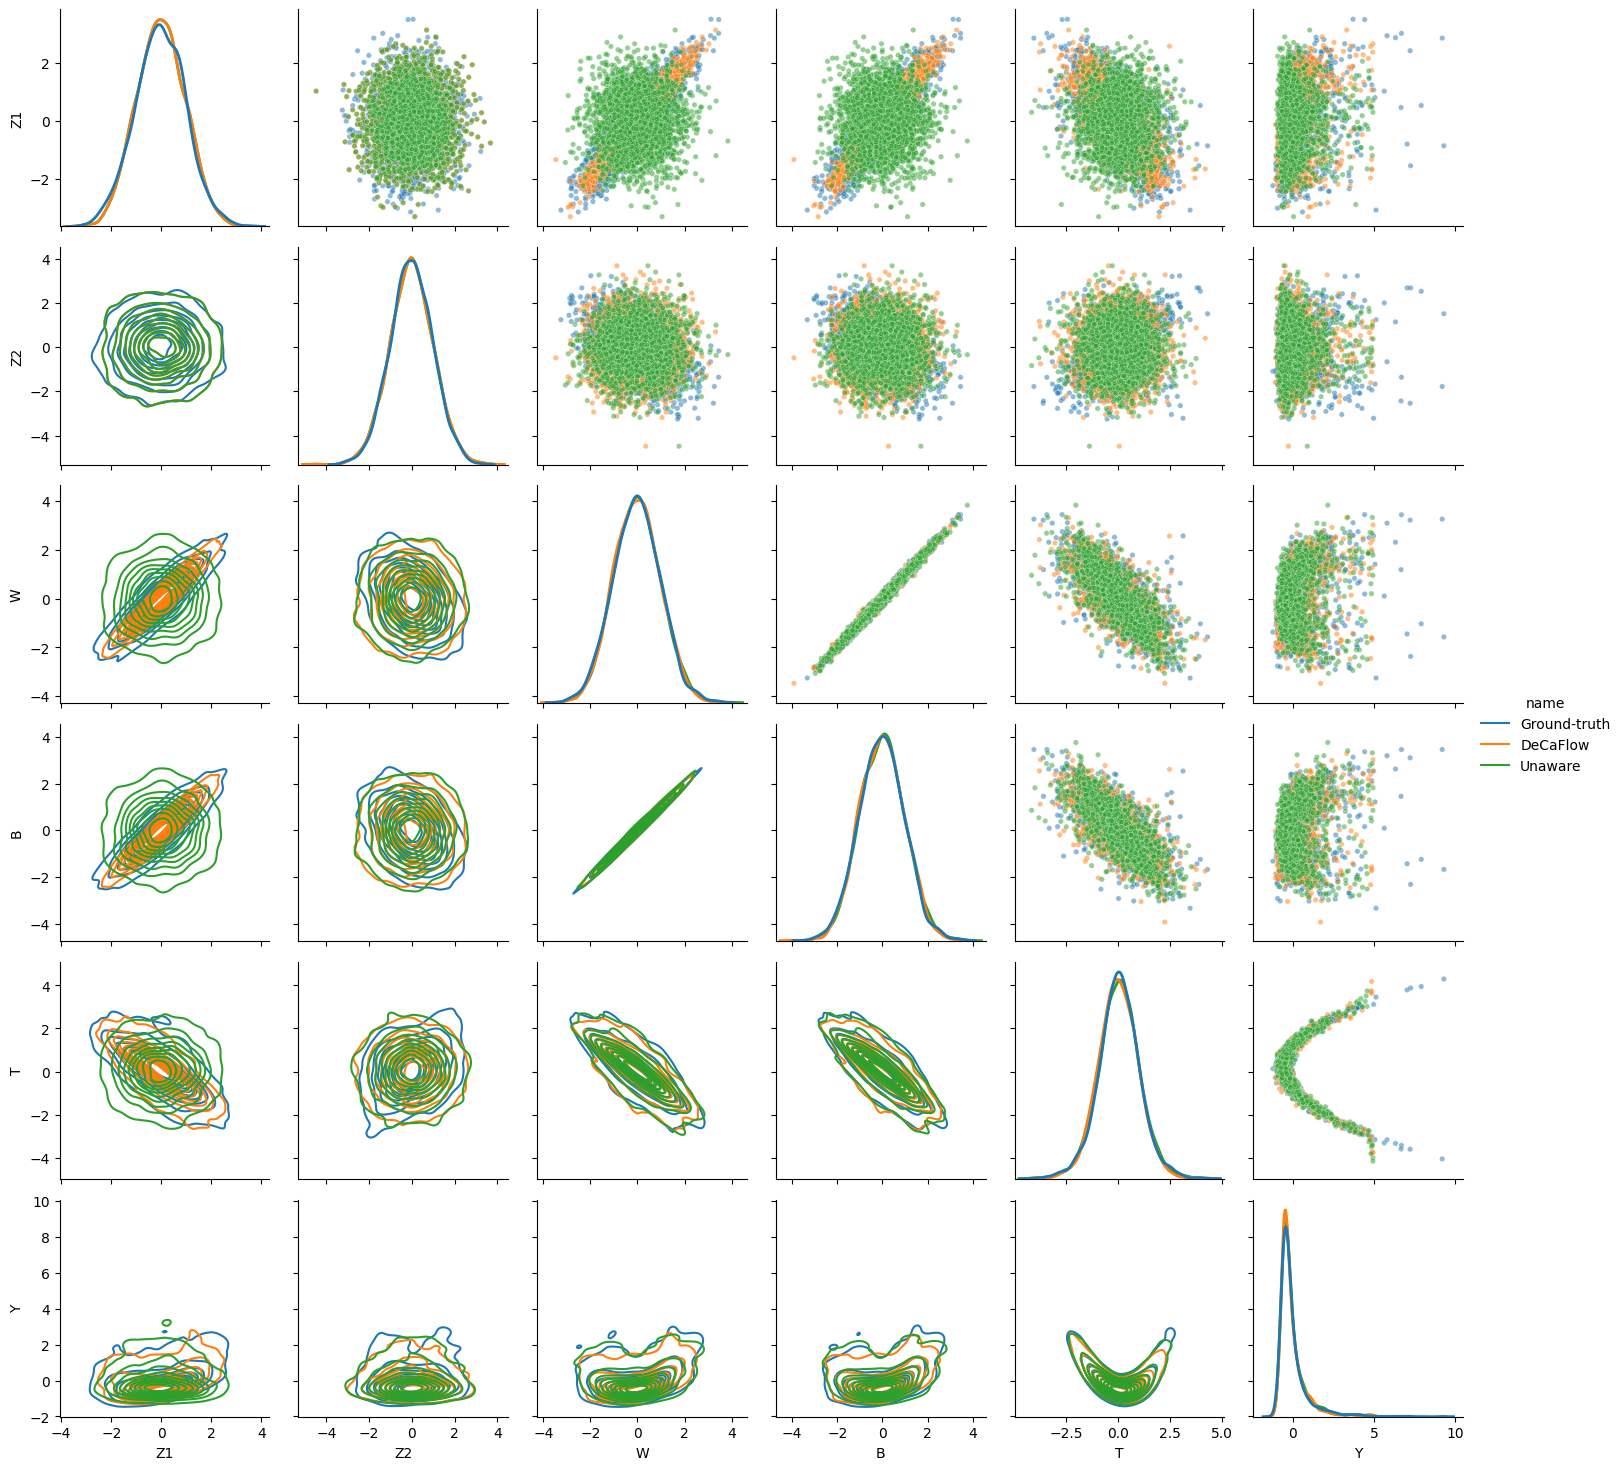

In [18]:
from decaflow.utils.plot import plot_data
num_samples = 512
g = plot_data({'Ground-truth': test_data[:num_samples], 'DeCaFlow': gen_data[:num_samples], 'Unaware':gen_data_unaware[:num_samples]}, columns=columns)

In [19]:
torch.quantile(train_data[:, -2], 0.99), torch.quantile(train_data[:, 4], 0.99)

(tensor(2.4621), tensor(2.4621))

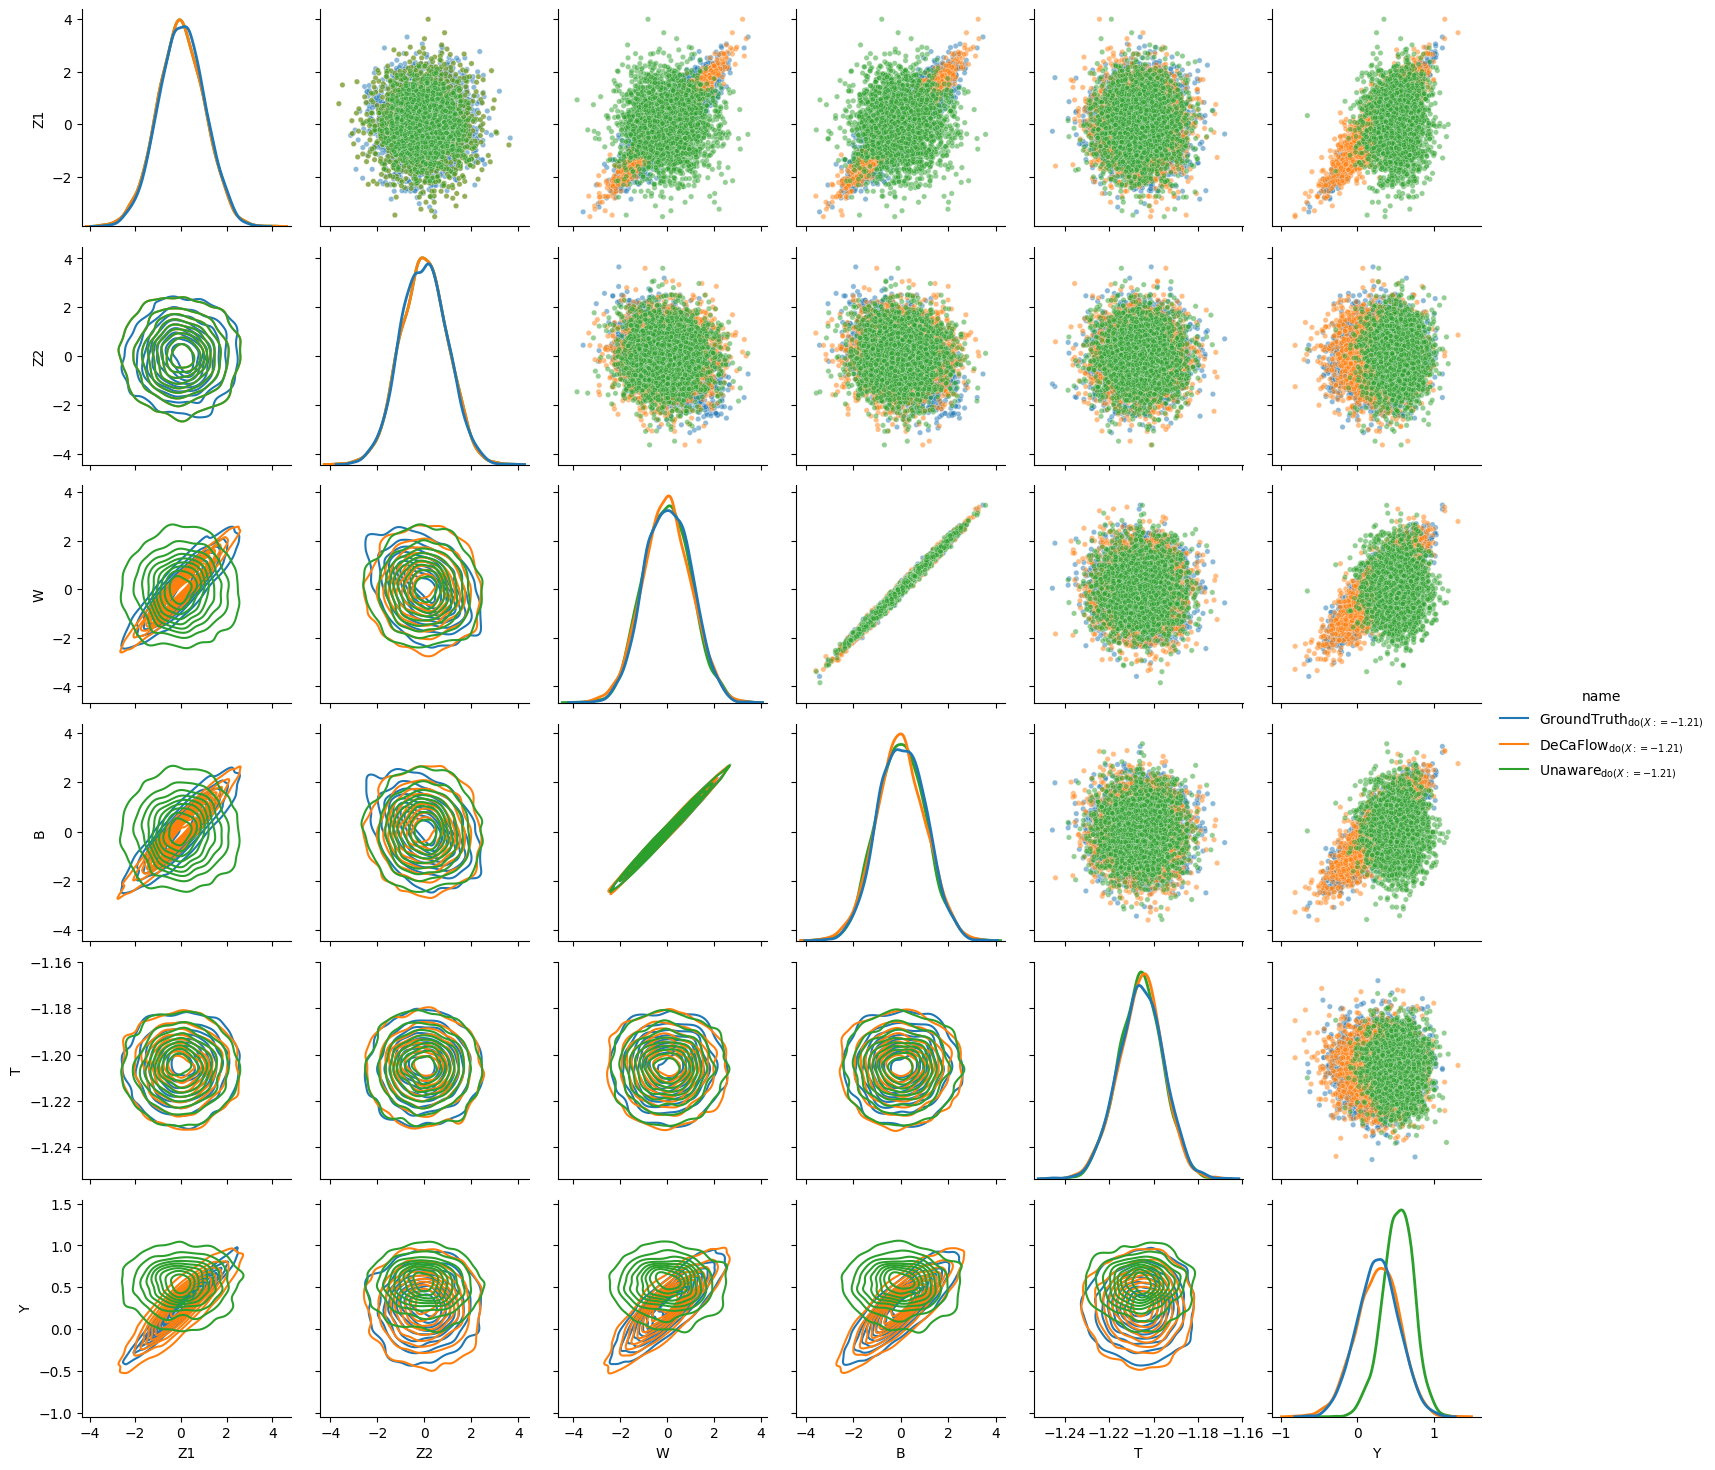

In [20]:
index = 4
value = torch.quantile(train_data[:, index], 0.1)

true_int_data = generate_int_data(test_size, index, value * sigma[index] + mu[index])
true_int_data = (true_int_data - mu) / sigma

#interventional data with decaflow
x_int, z_int = decaflow.sample_interventional(index-num_hidden, value, (test_size, ))
int_data = torch.cat((z_int, x_int), dim=1)

#interventional data with unaware flow
x_int_unaware, _ = unaware_flow.sample_interventional(index-num_hidden, value, (test_size, ))
int_data_unaware = torch.cat((z_int, x_int_unaware), dim=1)


int_data[:, index] += torch.randn((test_size,)) * 0.01
true_int_data[:, index] += torch.randn((test_size,)) * 0.01
int_data_unaware[:, index] += torch.randn((test_size,)) * 0.01

num_samples = 512

g = plot_data({
    r'$\text{GroundTruth}_{\mathrm{do}(X :=' + f'{float(value):.2f}' + r')}$': true_int_data[:num_samples],
    r'$\text{DeCaFlow}_{\mathrm{do}(X :=' + f'{float(value):.2f}' + r')}$': int_data[:num_samples],
    r'$\text{Unaware}_{\mathrm{do}(X :=' + f'{float(value):.2f}' + r')}$': int_data_unaware[:num_samples],
}, columns=columns)



In [21]:
J = decaflow.compute_jacobian(x = x_test)
display(J.mean(axis=0))

array([[ 2.8034039,  0.       ,  0.       ,  0.       ],
       [-6.225582 ,  9.419791 ,  0.       ,  0.       ],
       [ 0.       ,  4.4533424,  5.564461 ,  0.       ],
       [ 0.       ,  0.       , -0.0212914,  3.5372102]], dtype=float32)

In [22]:
J.mean(axis=0)

array([[ 2.8034039,  0.       ,  0.       ,  0.       ],
       [-6.225582 ,  9.419791 ,  0.       ,  0.       ],
       [ 0.       ,  4.4533424,  5.564461 ,  0.       ],
       [ 0.       ,  0.       , -0.0212914,  3.5372102]], dtype=float32)

In [23]:
p_u = torch.distributions.Normal(torch.zeros([test_size, n_features]), scale=1)
u = p_u.sample()
G = decaflow.compute_jacobian(u = u)
display(G.mean(axis=0))

array([[ 0.2734634 ,  0.        ,  0.        ,  0.        ],
       [ 0.2724248 ,  0.10731476,  0.        ,  0.        ],
       [-0.21611696, -0.08507408,  0.19694445,  0.        ],
       [ 0.02197232,  0.00814547, -0.02543946,  0.11798377]],
      dtype=float32)

In [24]:
G.mean(axis=0)

array([[ 0.2734634 ,  0.        ,  0.        ,  0.        ],
       [ 0.2724248 ,  0.10731476,  0.        ,  0.        ],
       [-0.21611696, -0.08507408,  0.19694445,  0.        ],
       [ 0.02197232,  0.00814547, -0.02543946,  0.11798377]],
      dtype=float32)

In [25]:
from decaflow.utils.metrics import get_ate_error, get_counterfactual_error
value_a = torch.quantile(train_data[:, index], 0.1)
value_b = torch.quantile(train_data[:, index], 0.9)
index_intervene = 4
index_eval = 5
ate_error = get_ate_error(flow=decaflow, scm=scm, num_hidden=num_hidden,
                      index_intervene=index_intervene,
                      value_intervene_a=value_a, value_intervene_b=value_b,
                      index_eval=index_eval,
                      scm_scale = sigma)
cf_error = get_counterfactual_error(flow=decaflow, scm=scm, num_hidden=num_hidden,
                                factual = test_data, # z and x
                                index_intervene=index_intervene,
                                value_intervene=value_a,
                                index_eval=index_eval,
                                scm_scale = sigma, scm_loc = mu)
print(f'ATE error: {ate_error:.4f}')
print(f'Counterfactual error: {cf_error:.4f}')

ATE error: 0.1172
Counterfactual error: 0.1180


In [26]:
# Unaware flow metrics
ate_error_unaware = get_ate_error(flow=unaware_flow, scm=scm, num_hidden=num_hidden,
                      index_intervene=index_intervene,
                      value_intervene_a=value_a, value_intervene_b=value_b,
                      index_eval=index_eval,
                      scm_scale = sigma)
cf_error_unaware = get_counterfactual_error(flow=unaware_flow, scm=scm, num_hidden=num_hidden,
                                factual = test_data,  # z and x
                                index_intervene=index_intervene,
                                value_intervene=value_a,
                                index_eval=index_eval,
                                scm_scale = sigma, scm_loc= mu)
print(f'ATE error: {ate_error_unaware:.4f}')
print(f'Counterfactual error: {cf_error_unaware:.4f}')

ATE error: 0.2180
Counterfactual error: 7.4055


TADA! ATE and Counterfactual Error achieved by DeCaFlow are much lower than errors commited by an unaware flow!! :)